Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1InFG9u6SJZJfUsEr6A-oqvvI_oZJl6d9'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1d32cwSV9lmpIxhBhSwtDo27GB9K3XQYb'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13867
Number of dev sentences:  2448
Number of test sentences:  27625
Number of words in the training dataset:  14450
Number of words in the dev dataset:  5242
Number of words in the test dataset:  21696
Tags in the training dataset: ['B-treatment', 'O', 'B-problem', 'I-treatment', 'B-test', 'I-problem', 'I-test']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-treatment', 'O', 'B-problem', 'I-treatment', 'B-test', 'I-problem', 'I-test']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-treatment', 'O', 'B-problem', 'I-treatment', 'B-test', 'I-problem', 'I-test']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 5851,0802338,O
1,Sentence: 15815,The,O
2,Sentence: 15815,visualized,O
3,Sentence: 15815,paranasal,O
4,Sentence: 15815,sinuses,O
5,Sentence: 15815,are,O
6,Sentence: 15815,clear,O
7,Sentence: 15815,.,O
8,Sentence: 4203,Chem-7,B-test
9,Sentence: 4203,:,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Admission', 'O'), ('Date', 'O'), (':', 'O')]

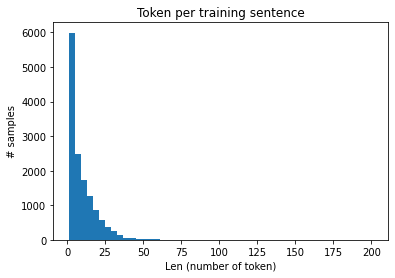

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

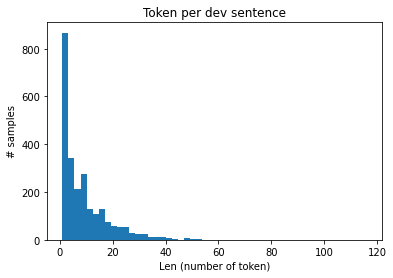

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

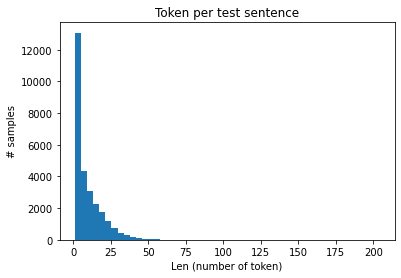

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

23128
Co
0
B-test


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9964)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13867
Points in y_train before removal: 13867
Points in X_train before removal: 50
Points in y_train before removal: 50


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[2813, 2363, 12116, 1150, 14794, 27816, 14419, 20268, 16096, 27816, 26506, 20268, 10466, 27816, 7702, 20268, 10129, 27816, 20504, 10412, 27816, 18105, 20268, 5977, 27816, 153, 20268, 8428, 27816, 21119, 4992, 27816, 12468]
[1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 4, 1, 1]
[817, 17568, 20404, 11422, 18781, 21564, 13838, 26638, 22707, 17087, 23136, 16826]
[2, 5, 5, 5, 5, 5, 1, 4, 6, 6, 6, 1]
[28164, 18001, 18169]
[1, 1, 1]
23128
0
B-problem
Jofredd
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 
     |████████████████████████████████| 120 kB 49.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=1cd3e4cfb833f9d2a290ac227fa342ac24259787b1838bce9f6d7580598e5c3f
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[2813, 2363, 12116, 1150, 14794, 27816, 14419, 20268, 16096,

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9960349798202515
Training loss epoch: 0.9198471367359161
Training accuracy epoch: 0.7072596874330979
Validating model...
Validation Loss: 1.4937067465348677
Validation Accuracy: 0.6477306495524866
Training epoch: 2
Training loss per 100 training steps: 0.3530976474285126
Training loss epoch: 0.3042079538106918
Training accuracy epoch: 0.9195311496467566
Validating model...
Validation Loss: 1.2533387208913829
Validation Accuracy: 0.650714518652726
Training epoch: 3
Training loss per 100 training steps: 0.2377290278673172
Training loss epoch: 0.16911887228488923
Training accuracy epoch: 0.9538193106401198
Validating model...
Validation Loss: 0.974616501238439
Validation Accuracy: 0.6983274920983917
Training epoch: 4
Training loss per 100 training steps: 0.13410277664661407
Training loss epoch: 0.09965112879872322
Training accuracy epoch: 0.9702654677799186
Validating model...
Validation Loss: 0.8880033702045292
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7468410208131429
Validation Accuracy: 0.7785585496768687
Validation duration: 5.311246966666666 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 29.0%
              precision    recall  f1-score   support

     problem       0.39      0.34      0.36    181111
        test       0.22      0.48      0.31    104790
   treatment       0.46      0.12      0.19    242286

   micro avg       0.32      0.27      0.29    528187
   macro avg       0.36      0.31      0.29    528187
weighted avg       0.39      0.27      0.27    528187

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.055783987045288
Training loss epoch: 0.9440414786338807
Training accuracy epoch: 0.656221365874545
Validating model...
Validation Loss: 1.3602856552446043
Validation Accuracy: 0.6500883697839549
Training epoch: 2
Training loss per 100 training steps: 0.36501821875572205
Training loss epoch: 0.2828627288341522
Training accuracy epoch: 0.9215778205951617
Validating model...
Validation Loss: 1.171678115795185
Validation Accuracy: 0.6740964195161276
Training epoch: 3
Training loss per 100 training steps: 0.18819524347782135
Training loss epoch: 0.15074912905693055
Training accuracy epoch: 0.9582187968315136
Validating model...
Validation Loss: 0.9519202159596728
Validation Accuracy: 0.727418350306775
Training epoch: 4
Training loss per 100 training steps: 0.0978466272354126
Training loss epoch: 0.09026203230023384
Training accuracy epoch: 0.977197602226504
Validating model...
Validation Loss: 0.9479447510335353
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6798762337615093
Validation Accuracy: 0.8230130515003493
Validation duration: 5.304112783333335 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 47.5%
              precision    recall  f1-score   support

     problem       0.40      0.49      0.44    181111
        test       0.35      0.52      0.42    104790
   treatment       0.67      0.46      0.55    242286

   micro avg       0.47      0.48      0.48    528187
   macro avg       0.47      0.49      0.47    528187
weighted avg       0.51      0.48      0.48    528187

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.110597610473633
Training loss epoch: 0.9795440256595611
Training accuracy epoch: 0.6717897666452579
Validating model...
Validation Loss: 1.4292051652809241
Validation Accuracy: 0.6474080533471054
Training epoch: 2
Training loss per 100 training steps: 0.298911988735199
Training loss epoch: 0.28389277756214143
Training accuracy epoch: 0.9205116677371012
Validating model...
Validation Loss: 1.17490232455266
Validation Accuracy: 0.6573877653423946
Training epoch: 3
Training loss per 100 training steps: 0.20260103046894073
Training loss epoch: 0.15323067009449004
Training accuracy epoch: 0.9527231856133589
Validating model...
Validation Loss: 0.923700577252871
Validation Accuracy: 0.7017298317046625
Training epoch: 4
Training loss per 100 training steps: 0.12137482315301895
Training loss epoch: 0.09229619055986404
Training accuracy epoch: 0.9761614215371441
Validating model...
Validation Loss: 0.8829179855136128
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7405503310815051
Validation Accuracy: 0.7697798683591611
Validation duration: 5.276389000000003 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 23.8%
              precision    recall  f1-score   support

     problem       0.33      0.29      0.31    181111
        test       0.20      0.47      0.29    104790
   treatment       0.33      0.06      0.10    242286

   micro avg       0.26      0.22      0.24    528187
   macro avg       0.29      0.27      0.23    528187
weighted avg       0.30      0.22      0.21    528187

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.072965621948242
Training loss epoch: 0.9618651747703553
Training accuracy epoch: 0.6760351102547635
Validating model...
Validation Loss: 1.469360079084124
Validation Accuracy: 0.6430955690507637
Training epoch: 2
Training loss per 100 training steps: 0.32710251212120056
Training loss epoch: 0.30234217643737793
Training accuracy epoch: 0.9179190751445088
Validating model...
Validation Loss: 1.199974324796107
Validation Accuracy: 0.6575966150994703
Training epoch: 3
Training loss per 100 training steps: 0.18800494074821472
Training loss epoch: 0.16730640828609467
Training accuracy epoch: 0.952663241275958
Validating model...
Validation Loss: 1.0054823841367448
Validation Accuracy: 0.7004052701062122
Training epoch: 4
Training loss per 100 training steps: 0.13087499141693115
Training loss epoch: 0.10134355872869491
Training accuracy epoch: 0.9685591950331836
Validating model...
Validation Loss: 0.9540639210056949
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7658825152450137
Validation Accuracy: 0.8140030500628503


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.268268016666662 minutes
F1-score (test): 43.0%
              precision    recall  f1-score   support

     problem       0.41      0.39      0.40    181111
        test       0.29      0.53      0.38    104790
   treatment       0.69      0.39      0.50    242286

   micro avg       0.44      0.42      0.43    528187
   macro avg       0.46      0.44      0.43    528187
weighted avg       0.51      0.42      0.44    528187

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2671282291412354
Training loss epoch: 1.0688069880008697
Training accuracy epoch: 0.6435452793834296
Validating model...
Validation Loss: 1.4941582493967824
Validation Accuracy: 0.6484473296961868
Training epoch: 2
Training loss per 100 training steps: 0.392593115568161
Training loss epoch: 0.323856583237648
Training accuracy epoch: 0.9192357096981375
Validating model...
Validation Loss: 1.262664863041469
Validation Accuracy: 0.6471297108777183
Training epoch: 3
Training loss per 100 training steps: 0.2019316405057907
Training loss epoch: 0.1807352513074875
Training accuracy epoch: 0.9523528152429886
Validating model...
Validation Loss: 1.0097573724660007
Validation Accuracy: 0.6846200831880872
Training epoch: 4
Training loss per 100 training steps: 0.12065920233726501
Training loss epoch: 0.11485818177461624
Training accuracy epoch: 0.9723827874116893
Validating model...
Validation Loss: 0.9193893376882974
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7113423542016082
Validation Accuracy: 0.8055350492399623
Validation duration: 5.23835588333333 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 42.3%
              precision    recall  f1-score   support

     problem       0.34      0.37      0.36    181111
        test       0.30      0.59      0.39    104790
   treatment       0.67      0.41      0.51    242286

   micro avg       0.41      0.43      0.42    528187
   macro avg       0.44      0.46      0.42    528187
weighted avg       0.48      0.43      0.43    528187

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9644049406051636
Training loss epoch: 0.8817296683788299
Training accuracy epoch: 0.7236202098051809
Validating model...
Validation Loss: 1.4325283610975588
Validation Accuracy: 0.6479993824513156
Training epoch: 2
Training loss per 100 training steps: 0.40488308668136597
Training loss epoch: 0.31328784823417666
Training accuracy epoch: 0.9198308713337615
Validating model...
Validation Loss: 1.202734889922204
Validation Accuracy: 0.6542386923218192
Training epoch: 3
Training loss per 100 training steps: 0.2634153962135315
Training loss epoch: 0.18176232874393464
Training accuracy epoch: 0.9433547420252623
Validating model...
Validation Loss: 0.9905616006293854
Validation Accuracy: 0.6956922215751197
Training epoch: 4
Training loss per 100 training steps: 0.11150480061769485
Training loss epoch: 0.10834734737873078
Training accuracy epoch: 0.9693598801113253
Validating model...
Validation Loss: 0.90379287050916
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7383019383306857
Validation Accuracy: 0.8208012721998185
Validation duration: 5.247196216666665 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 49.8%
              precision    recall  f1-score   support

     problem       0.35      0.36      0.36    181111
        test       0.39      0.58      0.46    104790
   treatment       0.73      0.57      0.64    242286

   micro avg       0.50      0.50      0.50    528187
   macro avg       0.49      0.50      0.49    528187
weighted avg       0.53      0.50      0.51    528187

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9714375734329224
Training loss epoch: 0.9198913753032685
Training accuracy epoch: 0.6996767287518733
Validating model...
Validation Loss: 1.4517135279519218
Validation Accuracy: 0.6482918904125146
Training epoch: 2
Training loss per 100 training steps: 0.3694668114185333
Training loss epoch: 0.28210848569869995
Training accuracy epoch: 0.9215178762577606
Validating model...
Validation Loss: 1.1649444536729292
Validation Accuracy: 0.6526307036498119
Training epoch: 3
Training loss per 100 training steps: 0.27126365900039673
Training loss epoch: 0.1662279337644577
Training accuracy epoch: 0.9514622136587455
Validating model...
Validation Loss: 0.9660000537897085
Validation Accuracy: 0.6948016001390543
Training epoch: 4
Training loss per 100 training steps: 0.11766032874584198
Training loss epoch: 0.09561910033226013
Training accuracy epoch: 0.9711817597944765
Validating model...
Validation Loss: 0.90994613666039
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6934761410510099
Validation Accuracy: 0.7867090729663458


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.275881233333333 minutes
F1-score (test): 31.0%
              precision    recall  f1-score   support

     problem       0.36      0.29      0.32    181111
        test       0.25      0.65      0.36    104790
   treatment       0.50      0.16      0.24    242286

   micro avg       0.32      0.30      0.31    528187
   macro avg       0.37      0.37      0.31    528187
weighted avg       0.40      0.30      0.29    528187

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.148693084716797
Training loss epoch: 0.9585493087768555
Training accuracy epoch: 0.6657118390066368
Validating model...
Validation Loss: 1.4391874492942514
Validation Accuracy: 0.6528868769515795
Training epoch: 2
Training loss per 100 training steps: 0.350586473941803
Training loss epoch: 0.29701409339904783
Training accuracy epoch: 0.9223035752515522
Validating model...
Validation Loss: 1.2987928018941508
Validation Accuracy: 0.6695305049738516
Training epoch: 3
Training loss per 100 training steps: 0.23198753595352173
Training loss epoch: 0.1685621529817581
Training accuracy epoch: 0.952823806465425
Validating model...
Validation Loss: 1.065488281188073
Validation Accuracy: 0.6941002043306101
Training epoch: 4
Training loss per 100 training steps: 0.12542225420475006
Training loss epoch: 0.0942289799451828
Training accuracy epoch: 0.972382787411689
Validating model...
Validation Loss: 0.9698648986878333
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6987656897830742
Validation Accuracy: 0.7942806956325578
Validation duration: 5.2563918666666725 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 34.5%
              precision    recall  f1-score   support

     problem       0.40      0.43      0.41    181111
        test       0.22      0.59      0.32    104790
   treatment       0.56      0.20      0.30    242286

   micro avg       0.33      0.36      0.34    528187
   macro avg       0.39      0.41      0.34    528187
weighted avg       0.44      0.36      0.34    528187

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7030208110809326
Training loss epoch: 0.8144206821918487
Training accuracy epoch: 0.7619289231427959
Validating model...
Validation Loss: 1.4160681266289252
Validation Accuracy: 0.6476971537186422
Training epoch: 2
Training loss per 100 training steps: 0.3872656524181366
Training loss epoch: 0.2974860340356827
Training accuracy epoch: 0.9163776493256263
Validating model...
Validation Loss: 1.1929552229967983
Validation Accuracy: 0.6530150636250643
Training epoch: 3
Training loss per 100 training steps: 0.2545461356639862
Training loss epoch: 0.17449805438518523
Training accuracy epoch: 0.9549603939199315
Validating model...
Validation Loss: 0.9668196176553702
Validation Accuracy: 0.7126312177071583
Training epoch: 4
Training loss per 100 training steps: 0.0973016694188118
Training loss epoch: 0.09992429316043853
Training accuracy epoch: 0.972723185613359
Validating model...
Validation Loss: 0.9110281080394597
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.696611264306638
Validation Accuracy: 0.7969045982492277
Validation duration: 5.2847598166666705 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 36.4%
              precision    recall  f1-score   support

     problem       0.36      0.47      0.41    181111
        test       0.26      0.59      0.36    104790
   treatment       0.50      0.22      0.31    242286

   micro avg       0.35      0.38      0.36    528187
   macro avg       0.38      0.43      0.36    528187
weighted avg       0.41      0.38      0.36    528187

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.092224359512329
Training loss epoch: 0.9633168399333953
Training accuracy epoch: 0.6919653179190751
Validating model...
Validation Loss: 1.4258657461637025
Validation Accuracy: 0.6426716536635384
Training epoch: 2
Training loss per 100 training steps: 0.41698357462882996
Training loss epoch: 0.3064372956752777
Training accuracy epoch: 0.9184350246199958
Validating model...
Validation Loss: 1.2493199280330114
Validation Accuracy: 0.650428902135852
Training epoch: 3
Training loss per 100 training steps: 0.23676913976669312
Training loss epoch: 0.1726745769381523
Training accuracy epoch: 0.9522928709055876
Validating model...
Validation Loss: 1.0276376806296312
Validation Accuracy: 0.6941068910130226
Training epoch: 4
Training loss per 100 training steps: 0.1345289945602417
Training loss epoch: 0.10452783703804017
Training accuracy epoch: 0.9703960608006851
Validating model...
Validation Loss: 0.9915649519338237
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7993019585394197
Validation Accuracy: 0.758785823401333
Validation duration: 5.256768750000007 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 19.2%
              precision    recall  f1-score   support

     problem       0.25      0.18      0.21    181111
        test       0.17      0.58      0.27    104790
   treatment       0.28      0.02      0.03    242286

   micro avg       0.20      0.19      0.19    528187
   macro avg       0.23      0.26      0.17    528187
weighted avg       0.25      0.19      0.14    528187



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7925610542297363
Training loss epoch: 0.7426210556711469
Training accuracy epoch: 0.7645774195029527
Validating model...
Validation Loss: 1.369021394036033
Validation Accuracy: 0.6627801572340917
Training epoch: 2
Training loss per 100 training steps: 0.34336909651756287
Training loss epoch: 0.2150025942495891
Training accuracy epoch: 0.9401332554939693
Validating model...
Validation Loss: 0.9669018596797795
Validation Accuracy: 0.708644576183477
Training epoch: 3
Training loss per 100 training steps: 0.13666598498821259
Training loss epoch: 0.10540659193481718
Training accuracy epoch: 0.9713396719535099
Validating model...
Validation Loss: 0.9438296982220241
Validation Accuracy: 0.7275859145067024
Training epoch: 4
Training loss per 100 training steps: 0.06849971413612366
Training loss epoch: 0.05636038577982357
Training accuracy epoch: 0.9865971673859436
Validating model...
Validation Loss: 0.8483754528033269
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7097908279824036
Validation Accuracy: 0.7802480851178816
Validation duration: 5.25940133333332 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 31.4%
              precision    recall  f1-score   support

     problem       0.45      0.38      0.41    181111
        test       0.21      0.67      0.32    104790
   treatment       0.41      0.14      0.20    242286

   micro avg       0.30      0.33      0.31    528187
   macro avg       0.36      0.40      0.31    528187
weighted avg       0.38      0.33      0.30    528187

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.363150119781494
Training loss epoch: 0.9021866534437452
Training accuracy epoch: 0.7076630897423646
Validating model...
Validation Loss: 1.4593909978866577
Validation Accuracy: 0.650140091002257
Training epoch: 2
Training loss per 100 training steps: 0.2863331437110901
Training loss epoch: 0.2612459106104715
Training accuracy epoch: 0.9251358963429661
Validating model...
Validation Loss: 1.0694059683130932
Validation Accuracy: 0.6885308498600026
Training epoch: 3
Training loss per 100 training steps: 0.18203890323638916
Training loss epoch: 0.12214984531913485
Training accuracy epoch: 0.9682261139517728
Validating model...
Validation Loss: 0.9274180438611415
Validation Accuracy: 0.7291868169977187
Training epoch: 4
Training loss per 100 training steps: 0.07876784354448318
Training loss epoch: 0.06280132915292468
Training accuracy epoch: 0.980860258665948
Validating model...
Validation Loss: 0.9375552713096916
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7114815825803412
Validation Accuracy: 0.797514707993321
Validation duration: 5.272181416666687 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 32.7%
              precision    recall  f1-score   support

     problem       0.42      0.39      0.40    181111
        test       0.19      0.66      0.29    104790
   treatment       0.54      0.21      0.30    242286

   micro avg       0.30      0.36      0.33    528187
   macro avg       0.38      0.42      0.33    528187
weighted avg       0.43      0.36      0.33    528187

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.13472318649292
Training loss epoch: 0.9088454416819981
Training accuracy epoch: 0.7112640296155858
Validating model...
Validation Loss: 1.4724070654286967
Validation Accuracy: 0.6503965007941168
Training epoch: 2
Training loss per 100 training steps: 0.4303880035877228
Training loss epoch: 0.27754825566496166
Training accuracy epoch: 0.9197293475922609
Validating model...
Validation Loss: 1.1046840517551868
Validation Accuracy: 0.6895976349423272
Training epoch: 3
Training loss per 100 training steps: 0.22634895145893097
Training loss epoch: 0.14915012461798532
Training accuracy epoch: 0.9584434867534053
Validating model...
Validation Loss: 0.9384165506858331
Validation Accuracy: 0.7227133151281161
Training epoch: 4
Training loss per 100 training steps: 0.09918233752250671
Training loss epoch: 0.07811105730278152
Training accuracy epoch: 0.9802737265382182
Validating model...
Validation Loss: 0.9428924507909007
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7086720357614534
Validation Accuracy: 0.80046729365855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.2628055499999995 minutes
F1-score (test): 34.5%
              precision    recall  f1-score   support

     problem       0.43      0.44      0.44    181111
        test       0.22      0.68      0.33    104790
   treatment       0.51      0.18      0.26    242286

   micro avg       0.32      0.37      0.34    528187
   macro avg       0.38      0.43      0.34    528187
weighted avg       0.42      0.37      0.33    528187

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0926456451416016
Training loss epoch: 0.8617836322103228
Training accuracy epoch: 0.7078691177248976
Validating model...
Validation Loss: 1.3545751649063904
Validation Accuracy: 0.6632466607597812
Training epoch: 2
Training loss per 100 training steps: 0.34461408853530884
Training loss epoch: 0.24087066096918924
Training accuracy epoch: 0.9330724182245064
Validating model...
Validation Loss: 0.9982469894669272
Validation Accuracy: 0.7042947048589937
Training epoch: 3
Training loss per 100 training steps: 0.16531577706336975
Training loss epoch: 0.12926603481173515
Training accuracy epoch: 0.9656011890788253
Validating model...
Validation Loss: 0.9787938037475983
Validation Accuracy: 0.7222458652346331
Training epoch: 4
Training loss per 100 training steps: 0.07003886252641678
Training loss epoch: 0.06422571199280876
Training accuracy epoch: 0.9821639398024798
Validating model...
Validation Loss: 0.9173941983805074
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6972246993747022
Validation Accuracy: 0.8001357772589215
Validation duration: 5.234485683333332 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 38.8%
              precision    recall  f1-score   support

     problem       0.30      0.43      0.35    181111
        test       0.26      0.68      0.37    104790
   treatment       0.64      0.34      0.44    242286

   micro avg       0.35      0.44      0.39    528187
   macro avg       0.40      0.48      0.39    528187
weighted avg       0.45      0.44      0.40    528187

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1834323406219482
Training loss epoch: 0.8662345835140773
Training accuracy epoch: 0.7091287610134034
Validating model...
Validation Loss: 1.4113486834934779
Validation Accuracy: 0.6620651905319106
Training epoch: 2
Training loss per 100 training steps: 0.3337240219116211
Training loss epoch: 0.2557623194796698
Training accuracy epoch: 0.9264880608928544
Validating model...
Validation Loss: 1.0091941379881524
Validation Accuracy: 0.7010271417175664
Training epoch: 3
Training loss per 100 training steps: 0.19127275049686432
Training loss epoch: 0.12309532293251582
Training accuracy epoch: 0.9636831111075624
Validating model...
Validation Loss: 0.9569256135395595
Validation Accuracy: 0.7323097278241222
Training epoch: 4
Training loss per 100 training steps: 0.06843391060829163
Training loss epoch: 0.07229266688227654
Training accuracy epoch: 0.9818188227109158
Validating model...
Validation Loss: 0.8566267714871989
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.715314903675958
Validation Accuracy: 0.7952893558245138
Validation duration: 5.288494449999992 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 35.1%
              precision    recall  f1-score   support

     problem       0.42      0.38      0.40    181111
        test       0.25      0.64      0.36    104790
   treatment       0.61      0.19      0.29    242286

   micro avg       0.36      0.35      0.35    528187
   macro avg       0.43      0.41      0.35    528187
weighted avg       0.47      0.35      0.34    528187

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.018178701400757
Training loss epoch: 0.783809802361897
Training accuracy epoch: 0.7437272485833899
Validating model...
Validation Loss: 1.4575218364789888
Validation Accuracy: 0.6414086436777653
Training epoch: 2
Training loss per 100 training steps: 0.315302312374115
Training loss epoch: 0.2322149681193488
Training accuracy epoch: 0.9345930747798313
Validating model...
Validation Loss: 1.064768978527614
Validation Accuracy: 0.6894185569020819
Training epoch: 3
Training loss per 100 training steps: 0.16587963700294495
Training loss epoch: 0.11902553055967603
Training accuracy epoch: 0.9703325380292355
Validating model...
Validation Loss: 0.9470976505960736
Validation Accuracy: 0.7213218953129134
Training epoch: 4
Training loss per 100 training steps: 0.06117822974920273
Training loss epoch: 0.06596552580595016
Training accuracy epoch: 0.9854289706303077
Validating model...
Validation Loss: 0.9094232893609381
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7380048574672805
Validation Accuracy: 0.7767665366789752
Validation duration: 5.255281766666667 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 30.4%
              precision    recall  f1-score   support

     problem       0.42      0.39      0.41    181111
        test       0.20      0.65      0.30    104790
   treatment       0.46      0.12      0.18    242286

   micro avg       0.29      0.31      0.30    528187
   macro avg       0.36      0.38      0.30    528187
weighted avg       0.40      0.31      0.28    528187

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2980196475982666
Training loss epoch: 0.8939803327832904
Training accuracy epoch: 0.6979303187130687
Validating model...
Validation Loss: 1.3832245476834186
Validation Accuracy: 0.6592866047084605
Training epoch: 2
Training loss per 100 training steps: 0.2697193920612335
Training loss epoch: 0.2734719749007906
Training accuracy epoch: 0.9151487028927663
Validating model...
Validation Loss: 1.139437729662115
Validation Accuracy: 0.6784670128360454
Training epoch: 3
Training loss per 100 training steps: 0.1516035497188568
Training loss epoch: 0.1317009021128927
Training accuracy epoch: 0.9638327339548513
Validating model...
Validation Loss: 0.8768519681769532
Validation Accuracy: 0.7266554162931335
Training epoch: 4
Training loss per 100 training steps: 0.06064160168170929
Training loss epoch: 0.07959026364343506
Training accuracy epoch: 0.9776536378819419
Validating model...
Validation Loss: 0.8887325339503103
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6433593110629806
Validation Accuracy: 0.8176250180516673
Validation duration: 5.247429749999992 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 46.3%
              precision    recall  f1-score   support

     problem       0.48      0.44      0.46    181111
        test       0.29      0.70      0.41    104790
   treatment       0.69      0.41      0.51    242286

   micro avg       0.45      0.48      0.46    528187
   macro avg       0.49      0.52      0.46    528187
weighted avg       0.54      0.48      0.47    528187

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1933014392852783
Training loss epoch: 0.8299552287374224
Training accuracy epoch: 0.7329198295016459
Validating model...
Validation Loss: 1.458359323538743
Validation Accuracy: 0.664236096786557
Training epoch: 2
Training loss per 100 training steps: 0.35619473457336426
Training loss epoch: 0.24386730790138245
Training accuracy epoch: 0.9297700043613517
Validating model...
Validation Loss: 0.9823924039865469
Validation Accuracy: 0.6962378444413345
Training epoch: 3
Training loss per 100 training steps: 0.12337556481361389
Training loss epoch: 0.11515345530850547
Training accuracy epoch: 0.966838506151414
Validating model...
Validation Loss: 0.809441866812768
Validation Accuracy: 0.7498452502279949
Training epoch: 4
Training loss per 100 training steps: 0.09576575458049774
Training loss epoch: 0.06534539642078536
Training accuracy epoch: 0.9833448302824734
Validating model...
Validation Loss: 0.8137856102609015
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6303225885386821
Validation Accuracy: 0.8001711104447325
Validation duration: 5.272245333333346 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 37.8%
              precision    recall  f1-score   support

     problem       0.41      0.40      0.41    181111
        test       0.22      0.69      0.33    104790
   treatment       0.60      0.31      0.41    242286

   micro avg       0.35      0.41      0.38    528187
   macro avg       0.41      0.46      0.38    528187
weighted avg       0.46      0.41      0.39    528187

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6038148403167725
Training loss epoch: 0.7558184734412602
Training accuracy epoch: 0.7733951081746129
Validating model...
Validation Loss: 1.3864642474558446
Validation Accuracy: 0.6480395029655333
Training epoch: 2
Training loss per 100 training steps: 0.3509375751018524
Training loss epoch: 0.24782807592834746
Training accuracy epoch: 0.9258739938890335
Validating model...
Validation Loss: 1.0232062703603273
Validation Accuracy: 0.6878970342158628
Training epoch: 3
Training loss per 100 training steps: 0.17117877304553986
Training loss epoch: 0.11809713340231351
Training accuracy epoch: 0.9677359209960236
Validating model...
Validation Loss: 0.9139817403508471
Validation Accuracy: 0.7238068144823396
Training epoch: 4
Training loss per 100 training steps: 0.09703531861305237
Training loss epoch: 0.058919786874737055
Training accuracy epoch: 0.9858710346988876
Validating model...
Validation Loss: 0.9026099064133384
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.775425540904204
Validation Accuracy: 0.7881163586348771
Validation duration: 5.270933933333314 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 28.9%
              precision    recall  f1-score   support

     problem       0.43      0.33      0.37    181111
        test       0.21      0.60      0.31    104790
   treatment       0.42      0.11      0.17    242286

   micro avg       0.30      0.28      0.29    528187
   macro avg       0.36      0.34      0.28    528187
weighted avg       0.38      0.28      0.27    528187

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.88492751121521
Training loss epoch: 0.8215734149728503
Training accuracy epoch: 0.7258608267616466
Validating model...
Validation Loss: 1.4145822788213755
Validation Accuracy: 0.6399507721068808
Training epoch: 2
Training loss per 100 training steps: 0.3749471604824066
Training loss epoch: 0.2499383773122515
Training accuracy epoch: 0.9314661520247073
Validating model...
Validation Loss: 1.0325502822925519
Validation Accuracy: 0.6695950139161043
Training epoch: 3
Training loss per 100 training steps: 0.1774083375930786
Training loss epoch: 0.12377293833664485
Training accuracy epoch: 0.9651134867613119
Validating model...
Validation Loss: 0.8486975632704697
Validation Accuracy: 0.7274657314712051
Training epoch: 4
Training loss per 100 training steps: 0.082252636551857
Training loss epoch: 0.06902448194367546
Training accuracy epoch: 0.9807817650381117
Validating model...
Validation Loss: 0.8431182689480967
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6654748946290325
Validation Accuracy: 0.7847618120322077
Validation duration: 5.248922583333327 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 33.0%
              precision    recall  f1-score   support

     problem       0.41      0.37      0.39    181111
        test       0.19      0.73      0.31    104790
   treatment       0.38      0.26      0.31    242286

   micro avg       0.29      0.39      0.33    528187
   macro avg       0.33      0.45      0.33    528187
weighted avg       0.35      0.39      0.34    528187



In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8569434881210327
Training loss epoch: 0.7371692173182964
Training accuracy epoch: 0.7571004719686653
Validating model...
Validation Loss: 1.357794442734161
Validation Accuracy: 0.6647520433581983
Training epoch: 2
Training loss per 100 training steps: 0.38889366388320923
Training loss epoch: 0.2152523137629032
Training accuracy epoch: 0.9371212774144183
Validating model...
Validation Loss: 0.9442662774742424
Validation Accuracy: 0.7058680070030738
Training epoch: 3
Training loss per 100 training steps: 0.12127520889043808
Training loss epoch: 0.09913785476237535
Training accuracy epoch: 0.9729417739916792
Validating model...
Validation Loss: 0.8954278966049095
Validation Accuracy: 0.7385800487552142
Training epoch: 4
Training loss per 100 training steps: 0.0594867467880249
Training loss epoch: 0.05312632489949465
Training accuracy epoch: 0.9872517045009063
Validating model...
Validation Loss: 0.8902927551950727
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7243982380325044
Validation Accuracy: 0.7931492538464252
Validation duration: 5.245396533333345 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 34.1%
              precision    recall  f1-score   support

     problem       0.43      0.42      0.43    181111
        test       0.20      0.75      0.31    104790
   treatment       0.53      0.20      0.29    242286

   micro avg       0.31      0.39      0.34    528187
   macro avg       0.39      0.46      0.34    528187
weighted avg       0.43      0.39      0.34    528187

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.170435905456543
Training loss epoch: 0.8150217458605766
Training accuracy epoch: 0.7263571781697339
Validating model...
Validation Loss: 1.4864434901770058
Validation Accuracy: 0.6702804782306399
Training epoch: 2
Training loss per 100 training steps: 0.35243505239486694
Training loss epoch: 0.2561910133808851
Training accuracy epoch: 0.9250984028270388
Validating model...
Validation Loss: 1.0996326277782391
Validation Accuracy: 0.6841686051280457
Training epoch: 3
Training loss per 100 training steps: 0.14896434545516968
Training loss epoch: 0.12763060443103313
Training accuracy epoch: 0.9645234126681237
Validating model...
Validation Loss: 1.0040746393141808
Validation Accuracy: 0.7105607299376314
Training epoch: 4
Training loss per 100 training steps: 0.0810401439666748
Training loss epoch: 0.06987748062238097
Training accuracy epoch: 0.9805392515822797
Validating model...
Validation Loss: 0.9382834109393033
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7844467181022521
Validation Accuracy: 0.7887758802405272
Validation duration: 5.242006250000001 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 29.1%
              precision    recall  f1-score   support

     problem       0.44      0.45      0.44    181111
        test       0.19      0.63      0.30    104790
   treatment       0.24      0.06      0.10    242286

   micro avg       0.28      0.31      0.29    528187
   macro avg       0.29      0.38      0.28    528187
weighted avg       0.30      0.31      0.26    528187

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9166500568389893
Training loss epoch: 0.801368921995163
Training accuracy epoch: 0.7448964459635308
Validating model...
Validation Loss: 1.361064804064763
Validation Accuracy: 0.6587597707332862
Training epoch: 2
Training loss per 100 training steps: 0.32370525598526
Training loss epoch: 0.23744522407650948
Training accuracy epoch: 0.9300691065695691
Validating model...
Validation Loss: 0.9430808920364875
Validation Accuracy: 0.6892920606685151
Training epoch: 3
Training loss per 100 training steps: 0.19812607765197754
Training loss epoch: 0.11836423259228468
Training accuracy epoch: 0.9690394812986494
Validating model...
Validation Loss: 0.8445139519579998
Validation Accuracy: 0.7260419991041094
Training epoch: 4
Training loss per 100 training steps: 0.07945384085178375
Training loss epoch: 0.057906392496079206
Training accuracy epoch: 0.9879523534912859
Validating model...
Validation Loss: 0.7959124716845426
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6410247813910246
Validation Accuracy: 0.8229133166674903
Validation duration: 5.236182433333367 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 44.7%
              precision    recall  f1-score   support

     problem       0.40      0.50      0.45    181111
        test       0.30      0.71      0.42    104790
   treatment       0.55      0.41      0.47    242286

   micro avg       0.40      0.50      0.45    528187
   macro avg       0.42      0.54      0.45    528187
weighted avg       0.45      0.50      0.45    528187

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.268383502960205
Training loss epoch: 0.8706210926175117
Training accuracy epoch: 0.7059004065048735
Validating model...
Validation Loss: 1.3720744182537128
Validation Accuracy: 0.6501181296569284
Training epoch: 2
Training loss per 100 training steps: 0.2697239816188812
Training loss epoch: 0.25009507313370705
Training accuracy epoch: 0.920127278799926
Validating model...
Validation Loss: 1.0002550606603746
Validation Accuracy: 0.6822600228073413
Training epoch: 3
Training loss per 100 training steps: 0.1380842924118042
Training loss epoch: 0.11054023634642363
Training accuracy epoch: 0.9740304104376392
Validating model...
Validation Loss: 0.8963858756152067
Validation Accuracy: 0.728868235393001
Training epoch: 4
Training loss per 100 training steps: 0.07279342412948608
Training loss epoch: 0.05222611431963742
Training accuracy epoch: 0.9879775509248742
Validating model...
Validation Loss: 0.8748879664904111
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6590537473007485
Validation Accuracy: 0.8097227997551973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.25810486666669 minutes
F1-score (test): 38.7%
              precision    recall  f1-score   support

     problem       0.40      0.44      0.42    181111
        test       0.24      0.73      0.36    104790
   treatment       0.58      0.29      0.38    242286

   micro avg       0.35      0.43      0.39    528187
   macro avg       0.41      0.49      0.39    528187
weighted avg       0.45      0.43      0.39    528187

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.086130142211914
Training loss epoch: 0.8075183294713497
Training accuracy epoch: 0.7257542317745383
Validating model...
Validation Loss: 1.391174622944423
Validation Accuracy: 0.671106336813694
Training epoch: 2
Training loss per 100 training steps: 0.4004378020763397
Training loss epoch: 0.2426596488803625
Training accuracy epoch: 0.9286303101932827
Validating model...
Validation Loss: 0.9630412025885149
Validation Accuracy: 0.6954165152800708
Training epoch: 3
Training loss per 100 training steps: 0.14329664409160614
Training loss epoch: 0.10910433297976851
Training accuracy epoch: 0.9710134453388211
Validating model...
Validation Loss: 0.8559568648214464
Validation Accuracy: 0.7268324569628506
Training epoch: 4
Training loss per 100 training steps: 0.08302231878042221
Training loss epoch: 0.049824197543784976
Training accuracy epoch: 0.9885563259613145
Validating model...
Validation Loss: 0.8390434554644993
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6750656702314262
Validation Accuracy: 0.8282326805212507
Validation duration: 5.262057100000008 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 51.9%
              precision    recall  f1-score   support

     problem       0.45      0.53      0.48    181111
        test       0.38      0.58      0.46    104790
   treatment       0.67      0.52      0.59    242286

   micro avg       0.50      0.54      0.52    528187
   macro avg       0.50      0.55      0.51    528187
weighted avg       0.53      0.54      0.53    528187

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2280001640319824
Training loss epoch: 0.838547345250845
Training accuracy epoch: 0.7178048104280987
Validating model...
Validation Loss: 1.4037781829957838
Validation Accuracy: 0.6603655359392324
Training epoch: 2
Training loss per 100 training steps: 0.37366482615470886
Training loss epoch: 0.24781855195760727
Training accuracy epoch: 0.9271294479753455
Validating model...
Validation Loss: 1.0160467361474965
Validation Accuracy: 0.6855966368042944
Training epoch: 3
Training loss per 100 training steps: 0.10661247372627258
Training loss epoch: 0.11568883992731571
Training accuracy epoch: 0.9691207024913171
Validating model...
Validation Loss: 0.9129544488795391
Validation Accuracy: 0.721258629988379
Training epoch: 4
Training loss per 100 training steps: 0.0557406060397625
Training loss epoch: 0.05563522782176733
Training accuracy epoch: 0.9881307439819295
Validating model...
Validation Loss: 0.9235488044751154
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7520277620879589
Validation Accuracy: 0.7843840355260371


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.241376233333297 minutes
F1-score (test): 29.9%
              precision    recall  f1-score   support

     problem       0.42      0.36      0.39    181111
        test       0.18      0.74      0.29    104790
   treatment       0.44      0.15      0.22    242286

   micro avg       0.27      0.34      0.30    528187
   macro avg       0.35      0.42      0.30    528187
weighted avg       0.38      0.34      0.29    528187

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2442588806152344
Training loss epoch: 0.8082134053111076
Training accuracy epoch: 0.7327370112169704
Validating model...
Validation Loss: 1.4522069584239612
Validation Accuracy: 0.6548726733556327
Training epoch: 2
Training loss per 100 training steps: 0.24832436442375183
Training loss epoch: 0.22086029313504696
Training accuracy epoch: 0.9331653040493433
Validating model...
Validation Loss: 1.0078591224435087
Validation Accuracy: 0.6985937703388806
Training epoch: 3
Training loss per 100 training steps: 0.14508970081806183
Training loss epoch: 0.10413348488509655
Training accuracy epoch: 0.9712337615202764
Validating model...
Validation Loss: 0.9497187911690056
Validation Accuracy: 0.7312917710554079
Training epoch: 4
Training loss per 100 training steps: 0.09931275993585587
Training loss epoch: 0.05102286580950022
Training accuracy epoch: 0.9865851343174187
Validating model...
Validation Loss: 0.9015949786483467
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.730783294265469
Validation Accuracy: 0.7870841331994046
Validation duration: 5.230351483333349 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 32.6%
              precision    recall  f1-score   support

     problem       0.42      0.44      0.43    181111
        test       0.20      0.68      0.32    104790
   treatment       0.45      0.15      0.22    242286

   micro avg       0.30      0.35      0.33    528187
   macro avg       0.36      0.42      0.32    528187
weighted avg       0.39      0.35      0.31    528187

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7979296445846558
Training loss epoch: 0.7558998540043831
Training accuracy epoch: 0.775778396809041
Validating model...
Validation Loss: 1.316396121854906
Validation Accuracy: 0.6693031913978766
Training epoch: 2
Training loss per 100 training steps: 0.23693417012691498
Training loss epoch: 0.20746683701872826
Training accuracy epoch: 0.9399493958256143
Validating model...
Validation Loss: 1.043552347591945
Validation Accuracy: 0.7097373350826204
Training epoch: 3
Training loss per 100 training steps: 0.13862422108650208
Training loss epoch: 0.10376838315278292
Training accuracy epoch: 0.9723415618179714
Validating model...
Validation Loss: 1.0477538163011724
Validation Accuracy: 0.7153766781027567
Training epoch: 4
Training loss per 100 training steps: 0.041459519416093826
Training loss epoch: 0.04415537603199482
Training accuracy epoch: 0.9904364194211801
Validating model...
Validation Loss: 0.9732445873223342
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7243389904637028
Validation Accuracy: 0.7988969893990102
Validation duration: 5.278219466666694 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 37.4%
              precision    recall  f1-score   support

     problem       0.37      0.33      0.35    181111
        test       0.19      0.70      0.30    104790
   treatment       0.64      0.38      0.48    242286

   micro avg       0.33      0.43      0.37    528187
   macro avg       0.40      0.47      0.38    528187
weighted avg       0.46      0.43      0.40    528187

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3347551822662354
Training loss epoch: 0.8143250904977322
Training accuracy epoch: 0.7330046682484076
Validating model...
Validation Loss: 1.5314265830176217
Validation Accuracy: 0.6686651394881515
Training epoch: 2
Training loss per 100 training steps: 0.31421881914138794
Training loss epoch: 0.2302217073738575
Training accuracy epoch: 0.9338987065113802
Validating model...
Validation Loss: 1.1313064330584044
Validation Accuracy: 0.6824106174063068
Training epoch: 3
Training loss per 100 training steps: 0.16279394924640656
Training loss epoch: 0.11419502831995487
Training accuracy epoch: 0.968916315087622
Validating model...
Validation Loss: 0.9684331811867751
Validation Accuracy: 0.7386971796322668
Training epoch: 4
Training loss per 100 training steps: 0.07790477573871613
Training loss epoch: 0.060420655412599444
Training accuracy epoch: 0.9836826464285107
Validating model...
Validation Loss: 0.9555319021274518
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7607234521872468
Validation Accuracy: 0.7947625748436566


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.309745549999994 minutes
F1-score (test): 31.4%
              precision    recall  f1-score   support

     problem       0.39      0.50      0.44    181111
        test       0.21      0.58      0.31    104790
   treatment       0.30      0.12      0.17    242286

   micro avg       0.29      0.34      0.31    528187
   macro avg       0.30      0.40      0.30    528187
weighted avg       0.31      0.34      0.29    528187

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.042304039001465
Training loss epoch: 0.7164098732173443
Training accuracy epoch: 0.7621627607033306
Validating model...
Validation Loss: 1.3985005044317864
Validation Accuracy: 0.6764817610030214
Training epoch: 2
Training loss per 100 training steps: 0.2374437153339386
Training loss epoch: 0.19401145074516535
Training accuracy epoch: 0.9446612084620876
Validating model...
Validation Loss: 0.9126846325861944
Validation Accuracy: 0.7000365261066221
Training epoch: 3
Training loss per 100 training steps: 0.11576096713542938
Training loss epoch: 0.0926648024469614
Training accuracy epoch: 0.9738676723482466
Validating model...
Validation Loss: 0.9366561189874426
Validation Accuracy: 0.7419088345623762
Training epoch: 4
Training loss per 100 training steps: 0.06968960165977478
Training loss epoch: 0.05472491029649973
Training accuracy epoch: 0.9852456493093368
Validating model...
Validation Loss: 0.8649723715596385
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6936904967383102
Validation Accuracy: 0.8064623332070525
Validation duration: 5.276858800000022 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 37.9%
              precision    recall  f1-score   support

     problem       0.36      0.29      0.32    181111
        test       0.25      0.65      0.36    104790
   treatment       0.63      0.34      0.44    242286

   micro avg       0.37      0.39      0.38    528187
   macro avg       0.41      0.43      0.38    528187
weighted avg       0.46      0.39      0.39    528187



In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1347668170928955
Training loss epoch: 0.7800578706794314
Training accuracy epoch: 0.7416423236430132
Validating model...
Validation Loss: 1.287576743534633
Validation Accuracy: 0.6776609772382371
Training epoch: 2
Training loss per 100 training steps: 0.2558268904685974
Training loss epoch: 0.1969152722093794
Training accuracy epoch: 0.9435877078956446
Validating model...
Validation Loss: 0.9427352570868158
Validation Accuracy: 0.7095768632451281
Training epoch: 3
Training loss per 100 training steps: 0.09993032366037369
Training loss epoch: 0.08032417214579052
Training accuracy epoch: 0.9802078688969718
Validating model...
Validation Loss: 0.9025228077715094
Validation Accuracy: 0.7464347421365517
Training epoch: 4
Training loss per 100 training steps: 0.045211341232061386
Training loss epoch: 0.03757031655146016
Training accuracy epoch: 0.9933864174509297
Validating model...
Validation Loss: 0.9758308336332246
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7196357159150971
Validation Accuracy: 0.7973758242840873
Validation duration: 5.289298633333359 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 34.0%
              precision    recall  f1-score   support

     problem       0.43      0.52      0.47    181111
        test       0.22      0.65      0.32    104790
   treatment       0.48      0.12      0.19    242286

   micro avg       0.32      0.36      0.34    528187
   macro avg       0.37      0.43      0.33    528187
weighted avg       0.41      0.36      0.31    528187

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4952526092529297
Training loss epoch: 0.8326181901825799
Training accuracy epoch: 0.7309675655592741
Validating model...
Validation Loss: 1.3732634179003826
Validation Accuracy: 0.6680337487648754
Training epoch: 2
Training loss per 100 training steps: 0.3430117070674896
Training loss epoch: 0.20324182593160206
Training accuracy epoch: 0.9375935649459185
Validating model...
Validation Loss: 0.9338974225056635
Validation Accuracy: 0.7094323203469521
Training epoch: 3
Training loss per 100 training steps: 0.13711409270763397
Training loss epoch: 0.09339457460575634
Training accuracy epoch: 0.9752746902289634
Validating model...
Validation Loss: 0.9597314069797467
Validation Accuracy: 0.7315444206694828
Training epoch: 4
Training loss per 100 training steps: 0.05600716173648834
Training loss epoch: 0.04554337883989016
Training accuracy epoch: 0.9869463293224796
Validating model...
Validation Loss: 0.8553124735881756
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.710367459113951
Validation Accuracy: 0.78823863401643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.283588816666694 minutes
F1-score (test): 33.8%
              precision    recall  f1-score   support

     problem       0.34      0.29      0.31    181111
        test       0.20      0.72      0.32    104790
   treatment       0.58      0.30      0.39    242286

   micro avg       0.31      0.38      0.34    528187
   macro avg       0.37      0.43      0.34    528187
weighted avg       0.42      0.38      0.35    528187

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9149423837661743
Training loss epoch: 0.7159127725495232
Training accuracy epoch: 0.7712856077148472
Validating model...
Validation Loss: 1.358236077543977
Validation Accuracy: 0.6735325961424823
Training epoch: 2
Training loss per 100 training steps: 0.22132381796836853
Training loss epoch: 0.18999828067090777
Training accuracy epoch: 0.9411960401287176
Validating model...
Validation Loss: 0.8841358423233032
Validation Accuracy: 0.7183781992129633
Training epoch: 3
Training loss per 100 training steps: 0.08142126351594925
Training loss epoch: 0.08622131372491519
Training accuracy epoch: 0.9764481945912782
Validating model...
Validation Loss: 0.8714754147963091
Validation Accuracy: 0.7360126968396717
Training epoch: 4
Training loss per 100 training steps: 0.05202378332614899
Training loss epoch: 0.04441156031356917
Training accuracy epoch: 0.989260879743602
Validating model...
Validation Loss: 0.7872821502871328
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6207332607979575
Validation Accuracy: 0.8305461279723664
Validation duration: 5.281192133333328 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 53.3%
              precision    recall  f1-score   support

     problem       0.45      0.56      0.50    181111
        test       0.37      0.57      0.45    104790
   treatment       0.67      0.56      0.61    242286

   micro avg       0.51      0.56      0.53    528187
   macro avg       0.50      0.56      0.52    528187
weighted avg       0.54      0.56      0.54    528187

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0401012897491455
Training loss epoch: 0.7492701245678796
Training accuracy epoch: 0.7435114405561313
Validating model...
Validation Loss: 1.2880078074219938
Validation Accuracy: 0.6713480930064962
Training epoch: 2
Training loss per 100 training steps: 0.2784484922885895
Training loss epoch: 0.1836171117093828
Training accuracy epoch: 0.9460064120508063
Validating model...
Validation Loss: 0.8305474922254488
Validation Accuracy: 0.7425066606186934
Training epoch: 3
Training loss per 100 training steps: 0.09223601222038269
Training loss epoch: 0.07460391066140598
Training accuracy epoch: 0.9809615508878484
Validating model...
Validation Loss: 0.9235165761662768
Validation Accuracy: 0.7397187043233934
Training epoch: 4
Training loss per 100 training steps: 0.040826987475156784
Training loss epoch: 0.03138491821785768
Training accuracy epoch: 0.99328986984127
Validating model...
Validation Loss: 0.8324610064556073
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7388438022936936
Validation Accuracy: 0.8170577038043503
Validation duration: 5.2496766833333215 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 44.2%
              precision    recall  f1-score   support

     problem       0.47      0.31      0.38    181111
        test       0.25      0.62      0.36    104790
   treatment       0.64      0.50      0.56    242286

   micro avg       0.43      0.46      0.44    528187
   macro avg       0.45      0.48      0.43    528187
weighted avg       0.51      0.46      0.46    528187

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0447428226470947
Training loss epoch: 0.6962668829494052
Training accuracy epoch: 0.7793633246721497
Validating model...
Validation Loss: 1.3457132810122008
Validation Accuracy: 0.6752042634260351
Training epoch: 2
Training loss per 100 training steps: 0.2267562448978424
Training loss epoch: 0.17934385024838978
Training accuracy epoch: 0.9486986623333645
Validating model...
Validation Loss: 0.9124774638708536
Validation Accuracy: 0.7248123610349719
Training epoch: 3
Training loss per 100 training steps: 0.09494433552026749
Training loss epoch: 0.07520771813061503
Training accuracy epoch: 0.9798991584438039
Validating model...
Validation Loss: 0.9098460651063299
Validation Accuracy: 0.7579451582278773
Training epoch: 4
Training loss per 100 training steps: 0.05784875154495239
Training loss epoch: 0.03394907464583715
Training accuracy epoch: 0.9926013464290769
Validating model...
Validation Loss: 0.9401406684479157
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6869833801562587
Validation Accuracy: 0.8167560145253772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.264990733333312 minutes
F1-score (test): 44.6%
              precision    recall  f1-score   support

     problem       0.40      0.53      0.45    181111
        test       0.35      0.60      0.44    104790
   treatment       0.54      0.37      0.44    242286

   micro avg       0.42      0.47      0.45    528187
   macro avg       0.43      0.50      0.45    528187
weighted avg       0.45      0.47      0.45    528187

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.139620304107666
Training loss epoch: 0.7636006474494934
Training accuracy epoch: 0.7538984605458475
Validating model...
Validation Loss: 1.3811941982863785
Validation Accuracy: 0.668091945200929
Training epoch: 2
Training loss per 100 training steps: 0.22866599261760712
Training loss epoch: 0.18562290403578016
Training accuracy epoch: 0.9476971029388103
Validating model...
Validation Loss: 0.9767381301173916
Validation Accuracy: 0.6947210012662344
Training epoch: 3
Training loss per 100 training steps: 0.13238117098808289
Training loss epoch: 0.08663208410143852
Training accuracy epoch: 0.9791428499748148
Validating model...
Validation Loss: 0.9007488496891864
Validation Accuracy: 0.7366052773488027
Training epoch: 4
Training loss per 100 training steps: 0.04546814039349556
Training loss epoch: 0.04050251696672705
Training accuracy epoch: 0.9912158233850396
Validating model...
Validation Loss: 0.9669466746317876
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.703355997800827
Validation Accuracy: 0.7979213359671723
Validation duration: 5.277127116666694 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 33.3%
              precision    recall  f1-score   support

     problem       0.35      0.34      0.34    181111
        test       0.21      0.64      0.32    104790
   treatment       0.57      0.24      0.34    242286

   micro avg       0.32      0.35      0.33    528187
   macro avg       0.38      0.41      0.33    528187
weighted avg       0.42      0.35      0.34    528187

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0038609504699707
Training loss epoch: 0.7264964365296893
Training accuracy epoch: 0.7603909384658543
Validating model...
Validation Loss: 1.3250831845518831
Validation Accuracy: 0.6708664934770265
Training epoch: 2
Training loss per 100 training steps: 0.3150061070919037
Training loss epoch: 0.19297130902608237
Training accuracy epoch: 0.9451045744090396
Validating model...
Validation Loss: 0.9682010667664664
Validation Accuracy: 0.7053267843771591
Training epoch: 3
Training loss per 100 training steps: 0.11135073751211166
Training loss epoch: 0.08284062147140503
Training accuracy epoch: 0.9768880426784585
Validating model...
Validation Loss: 0.9117789585869034
Validation Accuracy: 0.7406599508144652
Training epoch: 4
Training loss per 100 training steps: 0.05528748780488968
Training loss epoch: 0.041797243472602635
Training accuracy epoch: 0.9886403213675597
Validating model...
Validation Loss: 0.916329280122534
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6791659307286695
Validation Accuracy: 0.7930350436512259
Validation duration: 5.299141750000005 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 32.6%
              precision    recall  f1-score   support

     problem       0.35      0.39      0.37    181111
        test       0.24      0.64      0.35    104790
   treatment       0.40      0.18      0.25    242286

   micro avg       0.31      0.35      0.33    528187
   macro avg       0.33      0.41      0.32    528187
weighted avg       0.35      0.35      0.31    528187

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8129299879074097
Training loss epoch: 0.7995623548825582
Training accuracy epoch: 0.7354731893373441
Validating model...
Validation Loss: 1.4008535765982293
Validation Accuracy: 0.6709770528173623
Training epoch: 2
Training loss per 100 training steps: 0.41686397790908813
Training loss epoch: 0.24873535997337765
Training accuracy epoch: 0.9346921325097378
Validating model...
Validation Loss: 0.9336360723941357
Validation Accuracy: 0.7183603708620411
Training epoch: 3
Training loss per 100 training steps: 0.16298645734786987
Training loss epoch: 0.10442636575963762
Training accuracy epoch: 0.9710696178359299
Validating model...
Validation Loss: 0.8644079395702907
Validation Accuracy: 0.7456330441559396
Training epoch: 4
Training loss per 100 training steps: 0.03499415144324303
Training loss epoch: 0.046988603555493884
Training accuracy epoch: 0.9889340183299358
Validating model...
Validation Loss: 0.8695651432136436
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6472842704366755
Validation Accuracy: 0.8191857779892084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.296013100000042 minutes
F1-score (test): 46.7%
              precision    recall  f1-score   support

     problem       0.45      0.51      0.48    181111
        test       0.26      0.69      0.38    104790
   treatment       0.65      0.46      0.54    242286

   micro avg       0.42      0.52      0.47    528187
   macro avg       0.45      0.55      0.47    528187
weighted avg       0.50      0.52      0.49    528187

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3807618618011475
Training loss epoch: 0.8060827950636545
Training accuracy epoch: 0.7339618844440705
Validating model...
Validation Loss: 1.377797499879614
Validation Accuracy: 0.6523175374869538
Training epoch: 2
Training loss per 100 training steps: 0.27726972103118896
Training loss epoch: 0.20726894173357222
Training accuracy epoch: 0.9427251685977196
Validating model...
Validation Loss: 1.001184338873083
Validation Accuracy: 0.6772783353134539
Training epoch: 3
Training loss per 100 training steps: 0.10089802742004395
Training loss epoch: 0.08883173101478153
Training accuracy epoch: 0.9720522779664855
Validating model...
Validation Loss: 0.9354196430800797
Validation Accuracy: 0.7295460605003528
Training epoch: 4
Training loss per 100 training steps: 0.03329528495669365
Training loss epoch: 0.048874452917112246
Training accuracy epoch: 0.98890239348331
Validating model...
Validation Loss: 1.077554411702342
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7926471805268968
Validation Accuracy: 0.7553374037022479
Validation duration: 5.269959066666646 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 20.8%
              precision    recall  f1-score   support

     problem       0.28      0.17      0.21    181111
        test       0.16      0.71      0.26    104790
   treatment       0.27      0.07      0.11    242286

   micro avg       0.19      0.23      0.21    528187
   macro avg       0.24      0.32      0.19    528187
weighted avg       0.25      0.23      0.17    528187

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7189892530441284
Training loss epoch: 0.6968844102488624
Training accuracy epoch: 0.7903417805420501
Validating model...
Validation Loss: 1.31461568621846
Validation Accuracy: 0.650400771895476
Training epoch: 2
Training loss per 100 training steps: 0.3003920316696167
Training loss epoch: 0.1929037513004409
Training accuracy epoch: 0.9456644229818824
Validating model...
Validation Loss: 0.8982836039035351
Validation Accuracy: 0.7064146034268796
Training epoch: 3
Training loss per 100 training steps: 0.08982647955417633
Training loss epoch: 0.08364908728334638
Training accuracy epoch: 0.978888986297718
Validating model...
Validation Loss: 0.9098293138788892
Validation Accuracy: 0.748211377738113
Training epoch: 4
Training loss per 100 training steps: 0.05620615556836128
Training loss epoch: 0.04339714265531964
Training accuracy epoch: 0.9903680200759051
Validating model...
Validation Loss: 1.0298244388072522
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.765597157801191
Validation Accuracy: 0.7990085712126472
Validation duration: 5.272286100000019 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 35.1%
              precision    recall  f1-score   support

     problem       0.49      0.41      0.44    181111
        test       0.23      0.69      0.34    104790
   treatment       0.48      0.19      0.28    242286

   micro avg       0.34      0.37      0.35    528187
   macro avg       0.40      0.43      0.35    528187
weighted avg       0.43      0.37      0.35    528187



In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.096261739730835
Training loss epoch: 0.7888098984956742
Training accuracy epoch: 0.7476429428980135
Validating model...
Validation Loss: 1.4117479185005286
Validation Accuracy: 0.6478734648318675
Training epoch: 2
Training loss per 100 training steps: 0.2292807698249817
Training loss epoch: 0.21544042825698853
Training accuracy epoch: 0.9373216666586537
Validating model...
Validation Loss: 0.9462397632660804
Validation Accuracy: 0.6897830381330097
Training epoch: 3
Training loss per 100 training steps: 0.11068220436573029
Training loss epoch: 0.09384981095790863
Training accuracy epoch: 0.9741968685948349
Validating model...
Validation Loss: 1.0191994270721039
Validation Accuracy: 0.723979987859083
Training epoch: 4
Training loss per 100 training steps: 0.0482759028673172
Training loss epoch: 0.046595267578959466
Training accuracy epoch: 0.9872809456946452
Validating model...
Validation Loss: 1.0015161501896845
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7606866121016167
Validation Accuracy: 0.7786402344626182
Validation duration: 5.301055183333362 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 31.0%
              precision    recall  f1-score   support

     problem       0.35      0.37      0.36    181111
        test       0.21      0.72      0.32    104790
   treatment       0.46      0.16      0.24    242286

   micro avg       0.28      0.34      0.31    528187
   macro avg       0.34      0.42      0.31    528187
weighted avg       0.37      0.34      0.30    528187

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.790230393409729
Training loss epoch: 0.7129439949989319
Training accuracy epoch: 0.7819583191239647
Validating model...
Validation Loss: 1.229278363190688
Validation Accuracy: 0.6675311522433547
Training epoch: 2
Training loss per 100 training steps: 0.28881269693374634
Training loss epoch: 0.18086610436439515
Training accuracy epoch: 0.9449281425635172
Validating model...
Validation Loss: 0.9090966706152086
Validation Accuracy: 0.7331615426296113
Training epoch: 3
Training loss per 100 training steps: 0.10213033109903336
Training loss epoch: 0.07494717463850975
Training accuracy epoch: 0.9794065416410171
Validating model...
Validation Loss: 0.8608419546833286
Validation Accuracy: 0.7604098942044215
Training epoch: 4
Training loss per 100 training steps: 0.041974619030952454
Training loss epoch: 0.03159703649580479
Training accuracy epoch: 0.9940607908953257
Validating model...
Validation Loss: 0.8612265950673587
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6931841441050723
Validation Accuracy: 0.811186379361289
Validation duration: 5.299067549999988 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 45.3%
              precision    recall  f1-score   support

     problem       0.45      0.48      0.47    181111
        test       0.27      0.70      0.39    104790
   treatment       0.65      0.40      0.50    242286

   micro avg       0.42      0.49      0.45    528187
   macro avg       0.46      0.53      0.45    528187
weighted avg       0.51      0.49      0.47    528187

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8129632472991943
Training loss epoch: 0.6873343557119369
Training accuracy epoch: 0.7859448264872022
Validating model...
Validation Loss: 1.3008881079686152
Validation Accuracy: 0.6787061147579757
Training epoch: 2
Training loss per 100 training steps: 0.2954457998275757
Training loss epoch: 0.1997981607913971
Training accuracy epoch: 0.9449220481950175
Validating model...
Validation Loss: 0.9766026448893856
Validation Accuracy: 0.6898205307277223
Training epoch: 3
Training loss per 100 training steps: 0.07667280733585358
Training loss epoch: 0.0845830274745822
Training accuracy epoch: 0.9747244903844123
Validating model...
Validation Loss: 0.907734442840923
Validation Accuracy: 0.747259140836324
Training epoch: 4
Training loss per 100 training steps: 0.04346013814210892
Training loss epoch: 0.03846134534105659
Training accuracy epoch: 0.9909397966075586
Validating model...
Validation Loss: 0.9779394207062659
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7784261587593291
Validation Accuracy: 0.7668183748807811
Validation duration: 5.275041750000006 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 22.8%
              precision    recall  f1-score   support

     problem       0.33      0.26      0.29    181111
        test       0.17      0.65      0.26    104790
   treatment       0.28      0.06      0.10    242286

   micro avg       0.21      0.24      0.23    528187
   macro avg       0.26      0.32      0.22    528187
weighted avg       0.28      0.24      0.20    528187

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.286383867263794
Training loss epoch: 0.7361359119415283
Training accuracy epoch: 0.7583316544915876
Validating model...
Validation Loss: 1.4396521456829914
Validation Accuracy: 0.66983518836853
Training epoch: 2
Training loss per 100 training steps: 0.2896718978881836
Training loss epoch: 0.1792851708829403
Training accuracy epoch: 0.948138152733006
Validating model...
Validation Loss: 1.0410856798097685
Validation Accuracy: 0.7069531255566665
Training epoch: 3
Training loss per 100 training steps: 0.11048291623592377
Training loss epoch: 0.08329209387302398
Training accuracy epoch: 0.9764948934174269
Validating model...
Validation Loss: 1.055265192861681
Validation Accuracy: 0.7271236011636881
Training epoch: 4
Training loss per 100 training steps: 0.04619571939110756
Training loss epoch: 0.040903198346495626
Training accuracy epoch: 0.9907853060175018
Validating model...
Validation Loss: 1.0185794489724296
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8241484053432941
Validation Accuracy: 0.800729303140126
Validation duration: 5.287904183333315 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 34.9%
              precision    recall  f1-score   support

     problem       0.43      0.46      0.44    181111
        test       0.24      0.61      0.34    104790
   treatment       0.47      0.17      0.25    242286

   micro avg       0.34      0.36      0.35    528187
   macro avg       0.38      0.41      0.34    528187
weighted avg       0.41      0.36      0.33    528187

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1490466594696045
Training loss epoch: 0.7335432976484298
Training accuracy epoch: 0.7627370089911591
Validating model...
Validation Loss: 1.2273044493291285
Validation Accuracy: 0.6710027714290602
Training epoch: 2
Training loss per 100 training steps: 0.3117291033267975
Training loss epoch: 0.1687188684940338
Training accuracy epoch: 0.9514869087076476
Validating model...
Validation Loss: 0.954994824025538
Validation Accuracy: 0.706721759113158
Training epoch: 3
Training loss per 100 training steps: 0.06502249836921692
Training loss epoch: 0.06743177250027657
Training accuracy epoch: 0.9825019906303114
Validating model...
Validation Loss: 0.9047238052665413
Validation Accuracy: 0.7637747870836628
Training epoch: 4
Training loss per 100 training steps: 0.03217056393623352
Training loss epoch: 0.030113692209124566
Training accuracy epoch: 0.994849733650231
Validating model...
Validation Loss: 0.8694482941132087
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6577239658821512
Validation Accuracy: 0.8241525694295044
Validation duration: 5.255652249999972 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 50.4%
              precision    recall  f1-score   support

     problem       0.45      0.47      0.46    181111
        test       0.36      0.64      0.46    104790
   treatment       0.71      0.49      0.58    242286

   micro avg       0.50      0.51      0.50    528187
   macro avg       0.50      0.53      0.50    528187
weighted avg       0.55      0.51      0.51    528187

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2794299125671387
Training loss epoch: 0.7586530536413193
Training accuracy epoch: 0.7533906464572776
Validating model...
Validation Loss: 1.2839812411890401
Validation Accuracy: 0.667114742884552
Training epoch: 2
Training loss per 100 training steps: 0.31914597749710083
Training loss epoch: 0.18777149468660354
Training accuracy epoch: 0.9464593917613537
Validating model...
Validation Loss: 0.8900098552951565
Validation Accuracy: 0.7025492607147961
Training epoch: 3
Training loss per 100 training steps: 0.10829692333936691
Training loss epoch: 0.08402037285268307
Training accuracy epoch: 0.975774296987171
Validating model...
Validation Loss: 0.8977656356700054
Validation Accuracy: 0.7284478586540715
Training epoch: 4
Training loss per 100 training steps: 0.04330580309033394
Training loss epoch: 0.044263410940766336
Training accuracy epoch: 0.9919994866087702
Validating model...
Validation Loss: 0.8675519615024715
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.666591275897291
Validation Accuracy: 0.8271533109550929
Validation duration: 5.2734102166666466 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 48.2%
              precision    recall  f1-score   support

     problem       0.39      0.51      0.44    181111
        test       0.33      0.68      0.45    104790
   treatment       0.65      0.48      0.55    242286

   micro avg       0.44      0.53      0.48    528187
   macro avg       0.45      0.56      0.48    528187
weighted avg       0.49      0.53      0.49    528187

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.021888256072998
Training loss epoch: 0.7143150299787522
Training accuracy epoch: 0.7732706949638624
Validating model...
Validation Loss: 1.3045014545514986
Validation Accuracy: 0.6736219932832326
Training epoch: 2
Training loss per 100 training steps: 0.25179925560951233
Training loss epoch: 0.18921128585934638
Training accuracy epoch: 0.9445351893443013
Validating model...
Validation Loss: 0.9268185658888384
Validation Accuracy: 0.7087028275493704
Training epoch: 3
Training loss per 100 training steps: 0.07538294047117233
Training loss epoch: 0.08088326565921307
Training accuracy epoch: 0.9781636758772247
Validating model...
Validation Loss: 0.9185437420745949
Validation Accuracy: 0.744701192834482
Training epoch: 4
Training loss per 100 training steps: 0.037298157811164856
Training loss epoch: 0.03558937069028616
Training accuracy epoch: 0.9920974543932548
Validating model...
Validation Loss: 0.9574828697489454
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7052422310743067
Validation Accuracy: 0.8067888383449086
Validation duration: 5.289256899999964 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 37.7%
              precision    recall  f1-score   support

     problem       0.42      0.53      0.46    181111
        test       0.21      0.67      0.33    104790
   treatment       0.57      0.24      0.34    242286

   micro avg       0.34      0.42      0.38    528187
   macro avg       0.40      0.48      0.38    528187
weighted avg       0.44      0.42      0.38    528187

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7568411827087402
Training loss epoch: 0.6581513583660126
Training accuracy epoch: 0.7963007620340649
Validating model...
Validation Loss: 1.2596443860561817
Validation Accuracy: 0.6408895984415413
Training epoch: 2
Training loss per 100 training steps: 0.22972658276557922
Training loss epoch: 0.16074073910713196
Training accuracy epoch: 0.9544673099614938
Validating model...
Validation Loss: 0.972468410219465
Validation Accuracy: 0.7227649225224086
Training epoch: 3
Training loss per 100 training steps: 0.05525248870253563
Training loss epoch: 0.06238959394395351
Training accuracy epoch: 0.9857731731277543
Validating model...
Validation Loss: 0.9612564669026957
Validation Accuracy: 0.7290284198632144
Training epoch: 4
Training loss per 100 training steps: 0.037112314254045486
Training loss epoch: 0.028004011139273643
Training accuracy epoch: 0.9939222396095175
Validating model...
Validation Loss: 0.8476538294321531
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7649988534825819
Validation Accuracy: 0.7928127540535397
Validation duration: 5.2369959999999995 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 35.0%
              precision    recall  f1-score   support

     problem       0.41      0.44      0.42    181111
        test       0.21      0.70      0.32    104790
   treatment       0.48      0.23      0.31    242286

   micro avg       0.31      0.39      0.35    528187
   macro avg       0.36      0.46      0.35    528187
weighted avg       0.40      0.39      0.35    528187

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0596065521240234
Training loss epoch: 0.7468993097543717
Training accuracy epoch: 0.7477874181345232
Validating model...
Validation Loss: 1.19156915181643
Validation Accuracy: 0.6742888919794185
Training epoch: 2
Training loss per 100 training steps: 0.27254241704940796
Training loss epoch: 0.17290379777550696
Training accuracy epoch: 0.9508370118687168
Validating model...
Validation Loss: 0.8965349243832873
Validation Accuracy: 0.7195849792978353
Training epoch: 3
Training loss per 100 training steps: 0.08342377841472626
Training loss epoch: 0.06616950668394565
Training accuracy epoch: 0.9826801707211403
Validating model...
Validation Loss: 0.9729995278569011
Validation Accuracy: 0.7380978932607125
Training epoch: 4
Training loss per 100 training steps: 0.047625668346881866
Training loss epoch: 0.0278175612911582
Training accuracy epoch: 0.9955536181900044
Validating model...
Validation Loss: 0.9269984325805267
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6749676713650977
Validation Accuracy: 0.8316840067645621
Validation duration: 5.274608916666572 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 52.2%
              precision    recall  f1-score   support

     problem       0.44      0.54      0.48    181111
        test       0.41      0.60      0.49    104790
   treatment       0.64      0.52      0.58    242286

   micro avg       0.50      0.54      0.52    528187
   macro avg       0.50      0.55      0.52    528187
weighted avg       0.53      0.54      0.53    528187

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.057166576385498
Training loss epoch: 0.720049113035202
Training accuracy epoch: 0.7718839483996888
Validating model...
Validation Loss: 1.3500227835271266
Validation Accuracy: 0.6752955744225924
Training epoch: 2
Training loss per 100 training steps: 0.22821880877017975
Training loss epoch: 0.17387689501047135
Training accuracy epoch: 0.950749664684056
Validating model...
Validation Loss: 0.9615162378781802
Validation Accuracy: 0.7094987384792243
Training epoch: 3
Training loss per 100 training steps: 0.0868087187409401
Training loss epoch: 0.07908200472593307
Training accuracy epoch: 0.9758776279769432
Validating model...
Validation Loss: 0.9311710781865306
Validation Accuracy: 0.7356106681543793
Training epoch: 4
Training loss per 100 training steps: 0.03299393877387047
Training loss epoch: 0.03826238047331572
Training accuracy epoch: 0.9908755766624884
Validating model...
Validation Loss: 0.893482032534364
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7079656395923208
Validation Accuracy: 0.799959005673652
Validation duration: 5.29193868333338 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 39.8%
              precision    recall  f1-score   support

     problem       0.36      0.43      0.39    181111
        test       0.25      0.64      0.36    104790
   treatment       0.65      0.34      0.45    242286

   micro avg       0.37      0.43      0.40    528187
   macro avg       0.42      0.47      0.40    528187
weighted avg       0.47      0.43      0.41    528187



In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0054917335510254
Training loss epoch: 0.5577132552862167
Training accuracy epoch: 0.8251112209930097
Validating model...
Validation Loss: 1.0523429048525823
Validation Accuracy: 0.6789215909253651
Training epoch: 2
Training loss per 100 training steps: 0.1580909639596939
Training loss epoch: 0.10145255625247955
Training accuracy epoch: 0.973977469266623
Validating model...
Validation Loss: 0.8792422398344263
Validation Accuracy: 0.7588664200338796
Training epoch: 3
Training loss per 100 training steps: 0.04408750683069229
Training loss epoch: 0.031737509990731876
Training accuracy epoch: 0.99273521534526
Validating model...
Validation Loss: 0.9310238136873616
Validation Accuracy: 0.7606683946016451
Training epoch: 4
Training loss per 100 training steps: 0.01376750972121954
Training loss epoch: 0.009753098897635936
Training accuracy epoch: 0.9986101679915007
Validating model...
Validation Loss: 0.9039352373643355
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7357571866639234
Validation Accuracy: 0.7746541261360295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.2799868666666345 minutes
F1-score (test): 26.4%
              precision    recall  f1-score   support

     problem       0.30      0.26      0.28    181111
        test       0.21      0.67      0.32    104790
   treatment       0.40      0.11      0.17    242286

   micro avg       0.26      0.27      0.26    528187
   macro avg       0.30      0.35      0.26    528187
weighted avg       0.33      0.27      0.24    528187

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.955130696296692
Training loss epoch: 0.5238439530134201
Training accuracy epoch: 0.8297986238358714
Validating model...
Validation Loss: 0.9671965558807571
Validation Accuracy: 0.694012844934761
Training epoch: 2
Training loss per 100 training steps: 0.1261940747499466
Training loss epoch: 0.08525299280881882
Training accuracy epoch: 0.9769597514419426
Validating model...
Validation Loss: 0.8567350150702836
Validation Accuracy: 0.760869579456577
Training epoch: 3
Training loss per 100 training steps: 0.06730914115905762
Training loss epoch: 0.03464798169831435
Training accuracy epoch: 0.9919612061383354
Validating model...
Validation Loss: 0.9126011117712244
Validation Accuracy: 0.7501738570209606
Training epoch: 4
Training loss per 100 training steps: 0.012914084829390049
Training loss epoch: 0.012834464324017365
Training accuracy epoch: 0.9975071749330372
Validating model...
Validation Loss: 0.8527789023015406
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6655645973428532
Validation Accuracy: 0.8204840829461558
Validation duration: 5.260740433333315 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 49.8%
              precision    recall  f1-score   support

     problem       0.45      0.58      0.51    181111
        test       0.29      0.72      0.41    104790
   treatment       0.62      0.51      0.56    242286

   micro avg       0.44      0.57      0.50    528187
   macro avg       0.46      0.60      0.49    528187
weighted avg       0.50      0.57      0.51    528187

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.492302179336548
Training loss epoch: 0.6263177931308747
Training accuracy epoch: 0.8101398345549613
Validating model...
Validation Loss: 1.159480155288399
Validation Accuracy: 0.6797455780227327
Training epoch: 2
Training loss per 100 training steps: 0.19466489553451538
Training loss epoch: 0.11665880257884662
Training accuracy epoch: 0.9656277185311958
Validating model...
Validation Loss: 0.8943358775857208
Validation Accuracy: 0.7374998900389028
Training epoch: 3
Training loss per 100 training steps: 0.05170445144176483
Training loss epoch: 0.045479079335927965
Training accuracy epoch: 0.9901652243161707
Validating model...
Validation Loss: 0.8492388253088121
Validation Accuracy: 0.7686718897660719
Training epoch: 4
Training loss per 100 training steps: 0.026623373851180077
Training loss epoch: 0.02676844342301289
Training accuracy epoch: 0.9946750062830001
Validating model...
Validation Loss: 0.808249012216345
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6762797858704019
Validation Accuracy: 0.7972379290450846
Validation duration: 5.274827816666705 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 36.5%
              precision    recall  f1-score   support

     problem       0.36      0.45      0.40    181111
        test       0.24      0.64      0.35    104790
   treatment       0.59      0.24      0.34    242286

   micro avg       0.34      0.39      0.37    528187
   macro avg       0.40      0.44      0.36    528187
weighted avg       0.44      0.39      0.36    528187

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.922359585762024
Training loss epoch: 0.5213757087786992
Training accuracy epoch: 0.8363854021850653
Validating model...
Validation Loss: 1.028269125269605
Validation Accuracy: 0.6744764303625737
Training epoch: 2
Training loss per 100 training steps: 0.14037956297397614
Training loss epoch: 0.10068248137831688
Training accuracy epoch: 0.9737757970061759
Validating model...
Validation Loss: 0.9314226926147163
Validation Accuracy: 0.7485981713026619
Training epoch: 3
Training loss per 100 training steps: 0.08425109088420868
Training loss epoch: 0.03516493799785773
Training accuracy epoch: 0.9920945299221728
Validating model...
Validation Loss: 0.9385830295550359
Validation Accuracy: 0.751120720124439
Training epoch: 4
Training loss per 100 training steps: 0.009649092331528664
Training loss epoch: 0.011898388635988038
Training accuracy epoch: 0.9979690030548358
Validating model...
Validation Loss: 0.8384934276729435
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6904681830632465
Validation Accuracy: 0.8314842492484549
Validation duration: 5.236749966666684 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 49.0%
              precision    recall  f1-score   support

     problem       0.38      0.52      0.44    181111
        test       0.36      0.60      0.45    104790
   treatment       0.65      0.50      0.57    242286

   micro avg       0.46      0.53      0.49    528187
   macro avg       0.46      0.54      0.49    528187
weighted avg       0.50      0.53      0.50    528187

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1177103519439697
Training loss epoch: 0.6084193845589956
Training accuracy epoch: 0.8145633008857549
Validating model...
Validation Loss: 1.1373275804829288
Validation Accuracy: 0.6728770771403505
Training epoch: 2
Training loss per 100 training steps: 0.15904152393341064
Training loss epoch: 0.11129630878567695
Training accuracy epoch: 0.9702580152605715
Validating model...
Validation Loss: 0.884418510771417
Validation Accuracy: 0.7398760423189431
Training epoch: 3
Training loss per 100 training steps: 0.06888338923454285
Training loss epoch: 0.05119268658260504
Training accuracy epoch: 0.9866471411446803
Validating model...
Validation Loss: 0.7959718262994444
Validation Accuracy: 0.7811830742983874
Training epoch: 4
Training loss per 100 training steps: 0.027458185330033302
Training loss epoch: 0.02841412778943777
Training accuracy epoch: 0.993967080732391
Validating model...
Validation Loss: 0.7915063771334562
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6851494510278657
Validation Accuracy: 0.8043533787816467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 5.2393894999999855 minutes
F1-score (test): 42.8%
              precision    recall  f1-score   support

     problem       0.41      0.40      0.41    181111
        test       0.25      0.76      0.38    104790
   treatment       0.63      0.41      0.50    242286

   micro avg       0.39      0.48      0.43    528187
   macro avg       0.43      0.52      0.43    528187
weighted avg       0.48      0.48      0.44    528187

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1267337799072266
Training loss epoch: 0.5801174700260162
Training accuracy epoch: 0.8197748449409897
Validating model...
Validation Loss: 1.1836178736253218
Validation Accuracy: 0.6738579051782728
Training epoch: 2
Training loss per 100 training steps: 0.21595896780490875
Training loss epoch: 0.1261517124871413
Training accuracy epoch: 0.9649219347712069
Validating model...
Validation Loss: 0.8639707642716247
Validation Accuracy: 0.7406678327770408
Training epoch: 3
Training loss per 100 training steps: 0.04850156232714653
Training loss epoch: 0.04972331722577413
Training accuracy epoch: 0.9861137805642158
Validating model...
Validation Loss: 0.8894697435490497
Validation Accuracy: 0.7582472374112696
Training epoch: 4
Training loss per 100 training steps: 0.022353865206241608
Training loss epoch: 0.0196867806216081
Training accuracy epoch: 0.9949860911480674
Validating model...
Validation Loss: 0.8795221687911393
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6432493289725648
Validation Accuracy: 0.8157417081432916
Validation duration: 5.2665928166666465 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 46.4%
              precision    recall  f1-score   support

     problem       0.43      0.54      0.48    181111
        test       0.27      0.70      0.39    104790
   treatment       0.62      0.44      0.52    242286

   micro avg       0.41      0.53      0.46    528187
   macro avg       0.44      0.56      0.46    528187
weighted avg       0.48      0.53      0.48    528187

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.927740216255188
Training loss epoch: 0.5336586674054463
Training accuracy epoch: 0.8364413628377034
Validating model...
Validation Loss: 1.1346050973062392
Validation Accuracy: 0.6673701993358033
Training epoch: 2
Training loss per 100 training steps: 0.1868133693933487
Training loss epoch: 0.11689921965201695
Training accuracy epoch: 0.9674687614622829
Validating model...
Validation Loss: 0.9093626760817194
Validation Accuracy: 0.7388748015320519
Training epoch: 3
Training loss per 100 training steps: 0.04491372033953667
Training loss epoch: 0.06086964843173822
Training accuracy epoch: 0.9829161967332373
Validating model...
Validation Loss: 0.9755400868205281
Validation Accuracy: 0.7396909621903662
Training epoch: 4
Training loss per 100 training steps: 0.03485982120037079
Training loss epoch: 0.03366295173764229
Training accuracy epoch: 0.9914504934564814
Validating model...
Validation Loss: 0.8357811554685816
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6941634670451835
Validation Accuracy: 0.8060073413526005
Validation duration: 5.218039533333407 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 38.9%
              precision    recall  f1-score   support

     problem       0.41      0.38      0.39    181111
        test       0.25      0.70      0.37    104790
   treatment       0.49      0.34      0.40    242286

   micro avg       0.36      0.42      0.39    528187
   macro avg       0.38      0.47      0.39    528187
weighted avg       0.42      0.42      0.39    528187

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0517349243164062
Training loss epoch: 0.5408493210872014
Training accuracy epoch: 0.8307470821583168
Validating model...
Validation Loss: 1.0758350158666636
Validation Accuracy: 0.6947326540647806
Training epoch: 2
Training loss per 100 training steps: 0.14740723371505737
Training loss epoch: 0.1252693032224973
Training accuracy epoch: 0.964342589955796
Validating model...
Validation Loss: 1.0058869913026884
Validation Accuracy: 0.7320986163329126
Training epoch: 3
Training loss per 100 training steps: 0.06965655088424683
Training loss epoch: 0.06383978947997093
Training accuracy epoch: 0.9852903471715
Validating model...
Validation Loss: 0.9636883449244809
Validation Accuracy: 0.7593539505907779
Training epoch: 4
Training loss per 100 training steps: 0.04492450878024101
Training loss epoch: 0.04339034880201022
Training accuracy epoch: 0.9916559530579145
Validating model...
Validation Loss: 1.0247002282699982
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7647243700231667
Validation Accuracy: 0.7841123452570221
Validation duration: 5.290904050000003 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 28.5%
              precision    recall  f1-score   support

     problem       0.39      0.42      0.40    181111
        test       0.21      0.61      0.31    104790
   treatment       0.28      0.06      0.10    242286

   micro avg       0.28      0.29      0.29    528187
   macro avg       0.29      0.37      0.27    528187
weighted avg       0.30      0.29      0.25    528187

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0991125106811523
Training loss epoch: 0.5816994031270345
Training accuracy epoch: 0.8123421544596342
Validating model...
Validation Loss: 1.1547595177377974
Validation Accuracy: 0.6738460192518064
Training epoch: 2
Training loss per 100 training steps: 0.19140981137752533
Training loss epoch: 0.1088436911503474
Training accuracy epoch: 0.9676911542170448
Validating model...
Validation Loss: 0.9249230321351584
Validation Accuracy: 0.7288609473177138
Training epoch: 3
Training loss per 100 training steps: 0.0586056187748909
Training loss epoch: 0.04014650546014309
Training accuracy epoch: 0.9909684575672969
Validating model...
Validation Loss: 0.8011341451050399
Validation Accuracy: 0.7798332817366191
Training epoch: 4
Training loss per 100 training steps: 0.02300380915403366
Training loss epoch: 0.017541891460617385
Training accuracy epoch: 0.9968373575701447
Validating model...
Validation Loss: 0.8470527978686543
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6810669985220388
Validation Accuracy: 0.790606210528472
Validation duration: 5.239700850000008 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 34.0%
              precision    recall  f1-score   support

     problem       0.39      0.44      0.41    181111
        test       0.22      0.64      0.32    104790
   treatment       0.51      0.19      0.28    242286

   micro avg       0.32      0.36      0.34    528187
   macro avg       0.37      0.42      0.34    528187
weighted avg       0.41      0.36      0.33    528187

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1875133514404297
Training loss epoch: 0.6153116097052892
Training accuracy epoch: 0.8100210694692453
Validating model...
Validation Loss: 1.1433391214965225
Validation Accuracy: 0.6711822716067167
Training epoch: 2
Training loss per 100 training steps: 0.1922426074743271
Training loss epoch: 0.11743818074464799
Training accuracy epoch: 0.9689254769545814
Validating model...
Validation Loss: 0.8776325637643988
Validation Accuracy: 0.7391765799099194
Training epoch: 3
Training loss per 100 training steps: 0.05801912769675255
Training loss epoch: 0.045372236892580985
Training accuracy epoch: 0.9885283337913295
Validating model...
Validation Loss: 0.8769314614209262
Validation Accuracy: 0.7602613361129121
Training epoch: 4
Training loss per 100 training steps: 0.03260054811835289
Training loss epoch: 0.016442837193608284
Training accuracy epoch: 0.9969488845694717
Validating model...
Validation Loss: 0.8810665622934118
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7416189347428305
Validation Accuracy: 0.810216568933027
Validation duration: 5.232233233333318 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 41.3%
              precision    recall  f1-score   support

     problem       0.36      0.39      0.37    181111
        test       0.27      0.62      0.37    104790
   treatment       0.65      0.39      0.49    242286

   micro avg       0.39      0.44      0.41    528187
   macro avg       0.42      0.47      0.41    528187
weighted avg       0.47      0.44      0.43    528187



In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0641112327575684
Training loss epoch: 0.47059278190135956
Training accuracy epoch: 0.8566309838860073
Validating model...
Validation Loss: 1.1361482754930274
Validation Accuracy: 0.6774025255575788
Training epoch: 2
Training loss per 100 training steps: 0.10351625829935074
Training loss epoch: 0.07614923212677241
Training accuracy epoch: 0.9793822536867417
Validating model...
Validation Loss: 0.9769518011576169
Validation Accuracy: 0.7479118841600451
Training epoch: 3
Training loss per 100 training steps: 0.02556932158768177
Training loss epoch: 0.020060853683389723
Training accuracy epoch: 0.9954727084105194
Validating model...
Validation Loss: 0.8755794817751105
Validation Accuracy: 0.77945479405017
Training epoch: 4
Training loss per 100 training steps: 0.009757263585925102
Training loss epoch: 0.0071911239763721825
Training accuracy epoch: 0.9990143482731006
Validating model...
Validation Loss: 0.8977173907416207
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7002148482672594
Validation Accuracy: 0.8337455783422096
Validation duration: 5.26025165000004 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 55.1%
              precision    recall  f1-score   support

     problem       0.44      0.63      0.52    181111
        test       0.44      0.67      0.53    104790
   treatment       0.63      0.56      0.59    242286

   micro avg       0.51      0.60      0.55    528187
   macro avg       0.50      0.62      0.55    528187
weighted avg       0.53      0.60      0.56    528187

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7405734062194824
Training loss epoch: 0.4306309998035431
Training accuracy epoch: 0.8787299450299735
Validating model...
Validation Loss: 1.030810597655061
Validation Accuracy: 0.6940051860635487
Training epoch: 2
Training loss per 100 training steps: 0.08805231004953384
Training loss epoch: 0.06154867494478822
Training accuracy epoch: 0.9834713504999604
Validating model...
Validation Loss: 1.0001393479186218
Validation Accuracy: 0.7508763119690041
Training epoch: 3
Training loss per 100 training steps: 0.02789745107293129
Training loss epoch: 0.015436444920487702
Training accuracy epoch: 0.9967705702131067
Validating model...
Validation Loss: 0.8753726753321561
Validation Accuracy: 0.7826682624590778
Training epoch: 4
Training loss per 100 training steps: 0.009008738212287426
Training loss epoch: 0.006939638307085261
Training accuracy epoch: 0.9985819811873542
Validating model...
Validation Loss: 0.8980195770015964
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7872184748174967
Validation Accuracy: 0.7848688246599516
Validation duration: 5.254711950000031 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 33.0%
              precision    recall  f1-score   support

     problem       0.43      0.53      0.48    181111
        test       0.20      0.70      0.31    104790
   treatment       0.43      0.11      0.17    242286

   micro avg       0.30      0.37      0.33    528187
   macro avg       0.35      0.45      0.32    528187
weighted avg       0.38      0.37      0.30    528187

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9755388498306274
Training loss epoch: 0.4422831442207098
Training accuracy epoch: 0.8613621618812314
Validating model...
Validation Loss: 0.9504009910992214
Validation Accuracy: 0.705739690944666
Training epoch: 2
Training loss per 100 training steps: 0.10707636177539825
Training loss epoch: 0.0656054544262588
Training accuracy epoch: 0.9835553376258191
Validating model...
Validation Loss: 0.8132706385154229
Validation Accuracy: 0.7746339579258905
Training epoch: 3
Training loss per 100 training steps: 0.02632823958992958
Training loss epoch: 0.017289830697700383
Training accuracy epoch: 0.9969130372211448
Validating model...
Validation Loss: 0.8291288111116979
Validation Accuracy: 0.7833215843774132
Training epoch: 4
Training loss per 100 training steps: 0.01048806868493557
Training loss epoch: 0.01203656567959115
Training accuracy epoch: 0.9973947180014973
Validating model...
Validation Loss: 0.8961398392528682
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7136108366151651
Validation Accuracy: 0.7722592915469207
Validation duration: 5.2400419500000375 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 28.1%
              precision    recall  f1-score   support

     problem       0.32      0.34      0.33    181111
        test       0.19      0.65      0.30    104790
   treatment       0.41      0.13      0.20    242286

   micro avg       0.26      0.31      0.28    528187
   macro avg       0.31      0.38      0.28    528187
weighted avg       0.34      0.31      0.26    528187

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.795242428779602
Training loss epoch: 0.43005698882043364
Training accuracy epoch: 0.8718311666054479
Validating model...
Validation Loss: 0.9090046720071272
Validation Accuracy: 0.7062197590075794
Training epoch: 2
Training loss per 100 training steps: 0.07123786956071854
Training loss epoch: 0.06113365860655904
Training accuracy epoch: 0.98538873151679
Validating model...
Validation Loss: 0.8016891270488887
Validation Accuracy: 0.7701663043713156
Training epoch: 3
Training loss per 100 training steps: 0.03357347846031189
Training loss epoch: 0.019476710958406328
Training accuracy epoch: 0.9958871630585563
Validating model...
Validation Loss: 0.8022449194610893
Validation Accuracy: 0.7833664895433162
Training epoch: 4
Training loss per 100 training steps: 0.0038763724733144045
Training loss epoch: 0.006908182916231453
Training accuracy epoch: 0.998465444055984
Validating model...
Validation Loss: 0.794048814804523
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6759593356400728
Validation Accuracy: 0.820294026566667
Validation duration: 5.246020100000048 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 48.3%
              precision    recall  f1-score   support

     problem       0.38      0.46      0.41    181111
        test       0.30      0.74      0.43    104790
   treatment       0.69      0.52      0.59    242286

   micro avg       0.43      0.54      0.48    528187
   macro avg       0.46      0.57      0.48    528187
weighted avg       0.50      0.54      0.50    528187

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6471501588821411
Training loss epoch: 0.4118264835327864
Training accuracy epoch: 0.8847354664470479
Validating model...
Validation Loss: 0.931575467834225
Validation Accuracy: 0.7239734194644954
Training epoch: 2
Training loss per 100 training steps: 0.09117764979600906
Training loss epoch: 0.0537337807007134
Training accuracy epoch: 0.9865508124276999
Validating model...
Validation Loss: 0.8405149997054756
Validation Accuracy: 0.7727303451203654
Training epoch: 3
Training loss per 100 training steps: 0.01961001195013523
Training loss epoch: 0.018928746203891934
Training accuracy epoch: 0.9957801554487441
Validating model...
Validation Loss: 0.8164773358927144
Validation Accuracy: 0.7919055242048084
Training epoch: 4
Training loss per 100 training steps: 0.015324920415878296
Training loss epoch: 0.011765987030230463
Training accuracy epoch: 0.9975349459875155
Validating model...
Validation Loss: 0.8267731163408849
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8120445889179353
Validation Accuracy: 0.7989672747393549
Validation duration: 5.271852233333266 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 37.3%
              precision    recall  f1-score   support

     problem       0.37      0.43      0.40    181111
        test       0.24      0.67      0.36    104790
   treatment       0.52      0.28      0.36    242286

   micro avg       0.34      0.41      0.37    528187
   macro avg       0.38      0.46      0.37    528187
weighted avg       0.41      0.41      0.37    528187

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2957425117492676
Training loss epoch: 0.49054089933633804
Training accuracy epoch: 0.8503919102095955
Validating model...
Validation Loss: 1.0305713237106027
Validation Accuracy: 0.6843653701822157
Training epoch: 2
Training loss per 100 training steps: 0.14199574291706085
Training loss epoch: 0.07234093202278018
Training accuracy epoch: 0.9798392611977678
Validating model...
Validation Loss: 0.9389226761731234
Validation Accuracy: 0.7445544142131418
Training epoch: 3
Training loss per 100 training steps: 0.02963380515575409
Training loss epoch: 0.019264893466606738
Training accuracy epoch: 0.9958045722569334
Validating model...
Validation Loss: 0.9241766008463773
Validation Accuracy: 0.7612658453716803
Training epoch: 4
Training loss per 100 training steps: 0.01788404956459999
Training loss epoch: 0.008146685897372663
Training accuracy epoch: 0.9984545838891993
Validating model...
Validation Loss: 0.8302690649961496
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7001489724412009
Validation Accuracy: 0.8006559451968657
Validation duration: 5.227701416666727 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 38.8%
              precision    recall  f1-score   support

     problem       0.43      0.53      0.47    181111
        test       0.23      0.69      0.34    104790
   treatment       0.57      0.25      0.35    242286

   micro avg       0.35      0.43      0.39    528187
   macro avg       0.41      0.49      0.39    528187
weighted avg       0.45      0.43      0.39    528187

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2963109016418457
Training loss epoch: 0.49874204508960246
Training accuracy epoch: 0.8522450998933262
Validating model...
Validation Loss: 1.0219050011077484
Validation Accuracy: 0.6891441057224045
Training epoch: 2
Training loss per 100 training steps: 0.11095450818538666
Training loss epoch: 0.0642557630315423
Training accuracy epoch: 0.9842228490740957
Validating model...
Validation Loss: 0.9710747011296161
Validation Accuracy: 0.7570393177158539
Training epoch: 3
Training loss per 100 training steps: 0.03283390775322914
Training loss epoch: 0.024804834742099047
Training accuracy epoch: 0.9944452928528534
Validating model...
Validation Loss: 0.9723413586616516
Validation Accuracy: 0.7693731666347005
Training epoch: 4
Training loss per 100 training steps: 0.014867092482745647
Training loss epoch: 0.009182203258387745
Training accuracy epoch: 0.9981754720557131
Validating model...
Validation Loss: 0.8214586493256805
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.791325761695151
Validation Accuracy: 0.7903258545880658
Validation duration: 5.254009249999944 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 35.9%
              precision    recall  f1-score   support

     problem       0.39      0.54      0.45    181111
        test       0.21      0.68      0.32    104790
   treatment       0.51      0.20      0.29    242286

   micro avg       0.32      0.41      0.36    528187
   macro avg       0.37      0.48      0.35    528187
weighted avg       0.41      0.41      0.35    528187

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9964030981063843
Training loss epoch: 0.4895776942372322
Training accuracy epoch: 0.8528075976047489
Validating model...
Validation Loss: 1.069543486291712
Validation Accuracy: 0.693739884857262
Training epoch: 2
Training loss per 100 training steps: 0.1464478075504303
Training loss epoch: 0.07213789792731404
Training accuracy epoch: 0.982585937938083
Validating model...
Validation Loss: 0.9445721166474479
Validation Accuracy: 0.7670644032976034
Training epoch: 3
Training loss per 100 training steps: 0.04278669133782387
Training loss epoch: 0.02364992555230856
Training accuracy epoch: 0.995101672048564
Validating model...
Validation Loss: 1.0109851097131703
Validation Accuracy: 0.7608300613462282
Training epoch: 4
Training loss per 100 training steps: 0.006017544772475958
Training loss epoch: 0.00923146310960874
Training accuracy epoch: 0.9985284517315
Validating model...
Validation Loss: 0.9276519533875701
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8276158845810978
Validation Accuracy: 0.7913910628161106
Validation duration: 5.2331568166666935 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 34.8%
              precision    recall  f1-score   support

     problem       0.43      0.54      0.48    181111
        test       0.20      0.66      0.31    104790
   treatment       0.44      0.17      0.24    242286

   micro avg       0.31      0.39      0.35    528187
   macro avg       0.36      0.46      0.34    528187
weighted avg       0.39      0.39      0.34    528187

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.794573187828064
Training loss epoch: 0.4317135788500309
Training accuracy epoch: 0.8716801593080238
Validating model...
Validation Loss: 0.989876897304089
Validation Accuracy: 0.7039706615499737
Training epoch: 2
Training loss per 100 training steps: 0.11850890517234802
Training loss epoch: 0.0672090582549572
Training accuracy epoch: 0.9812771414306823
Validating model...
Validation Loss: 0.9545783849505635
Validation Accuracy: 0.7509944271247538
Training epoch: 3
Training loss per 100 training steps: 0.02069159597158432
Training loss epoch: 0.022784331208094956
Training accuracy epoch: 0.9945322903958009
Validating model...
Validation Loss: 0.9570507778749837
Validation Accuracy: 0.7622115893386104
Training epoch: 4
Training loss per 100 training steps: 0.005130203440785408
Training loss epoch: 0.009856430534273385
Training accuracy epoch: 0.9981679933742473
Validating model...
Validation Loss: 0.9172565379700104
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.8268846031278372
Validation Accuracy: 0.7954143847767682
Validation duration: 5.258679933333284 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 36.3%
              precision    recall  f1-score   support

     problem       0.43      0.47      0.45    181111
        test       0.21      0.71      0.32    104790
   treatment       0.43      0.26      0.32    242286

   micro avg       0.32      0.42      0.36    528187
   macro avg       0.36      0.48      0.37    528187
weighted avg       0.39      0.42      0.37    528187

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2185261249542236
Training loss epoch: 0.48504481837153435
Training accuracy epoch: 0.8505109816405962
Validating model...
Validation Loss: 1.0076969436236791
Validation Accuracy: 0.7038495022127328
Training epoch: 2
Training loss per 100 training steps: 0.08699851483106613
Training loss epoch: 0.06698936345055699
Training accuracy epoch: 0.9826602145464725
Validating model...
Validation Loss: 0.9013093516424104
Validation Accuracy: 0.7629981564264562
Training epoch: 3
Training loss per 100 training steps: 0.0386282280087471
Training loss epoch: 0.01622215888928622
Training accuracy epoch: 0.99665155695567
Validating model...
Validation Loss: 0.9117914693696159
Validation Accuracy: 0.7753800279632738
Training epoch: 4
Training loss per 100 training steps: 0.03027717024087906
Training loss epoch: 0.014090127043891698
Training accuracy epoch: 0.9973400679736771
Validating model...
Validation Loss: 0.9106111774196872
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.766891347658303
Validation Accuracy: 0.7826536749188414
Validation duration: 5.271359183333334 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 30.6%
              precision    recall  f1-score   support

     problem       0.41      0.40      0.41    181111
        test       0.20      0.68      0.31    104790
   treatment       0.42      0.13      0.19    242286

   micro avg       0.28      0.33      0.31    528187
   macro avg       0.34      0.40      0.30    528187
weighted avg       0.37      0.33      0.29    528187

